0:	learn: 1.1318751	total: 46.4ms	remaining: 834ms
1:	learn: 1.0253292	total: 47.1ms	remaining: 400ms
2:	learn: 0.9608460	total: 47.6ms	remaining: 254ms
3:	learn: 0.9389297	total: 48ms	remaining: 180ms
4:	learn: 0.9156884	total: 48.4ms	remaining: 136ms
5:	learn: 0.8932192	total: 48.8ms	remaining: 106ms
6:	learn: 0.8762077	total: 49.1ms	remaining: 84.2ms
7:	learn: 0.8621088	total: 49.5ms	remaining: 68ms
8:	learn: 0.8569982	total: 49.9ms	remaining: 55.4ms
9:	learn: 0.8512605	total: 50.3ms	remaining: 45.2ms
10:	learn: 0.8397778	total: 50.6ms	remaining: 36.8ms
11:	learn: 0.8329956	total: 51ms	remaining: 29.8ms
12:	learn: 0.8127305	total: 51.4ms	remaining: 23.7ms
13:	learn: 0.8065216	total: 51.7ms	remaining: 18.5ms
14:	learn: 0.7887853	total: 52.1ms	remaining: 13.9ms
15:	learn: 0.7716923	total: 52.4ms	remaining: 9.83ms
16:	learn: 0.7509803	total: 52.7ms	remaining: 6.21ms
17:	learn: 0.7470089	total: 53.1ms	remaining: 2.95ms
18:	learn: 0.7317302	total: 53.4ms	remaining: 0us
0:	learn: 1.099673

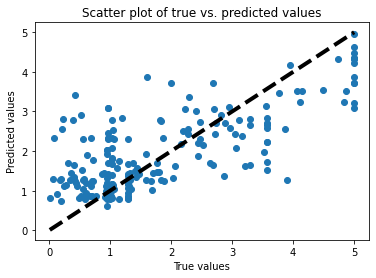

Training set:
R2: 0.6619905249306028
NSE: 0.6619905249306028
RMSE: 0.7752558247667695
MAE: 0.5706410158075272

Testing set:
R2: 0.5210810290220089
NSE: 0.5210810290220088
RMSE: 0.9490703380649486
MAE: 0.7231385090901749


In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Load and preprocess the dataset
data = pd.read_csv('VIS1S2PMETmGB.csv')

data = data.dropna() 
data['ET_wb'] = data['ET_wb'].astype(float)
#data_filtered = data[(data['ET_wb'] >= 0.1) & (data['ET_wb'] <= 0.35)]

X = data.iloc[:, [4,15]].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data.iloc[:, 19].values
y = y.reshape(-1, 1)
y = np.ravel(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=43)

# Define the CatBoost model
model = CatBoostRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [19],
    'depth': [5],
    'learning_rate': [0.5],
    'loss_function': ['RMSE'],
}

# Perform cross-validation using GridSearchCV
kfold = KFold(n_splits=5, shuffle=True, random_state=43)
cv_model = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error')
cv_model.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", cv_model.best_params_)

# Train the final model with the best hyperparameters
final_model = CatBoostRegressor(**cv_model.best_params_)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

T4GBSM1_CB = pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred.flatten()})

# Save the DataFrame to a file
T4GBSM1_CB.to_csv('GBSM12_CB.csv', index=False)

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()

y_train_pred = final_model.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred) / mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_rmse},
    {'Metric': 'R2', 'Value': train_r2},
    {'Metric': 'NSE', 'Value': train_nse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('CBGB_trainmetrics.csv', index=False)

y_test_pred = final_model.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred) / mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

testmetrics = [
    {'Metric': 'RMSE', 'Value': test_rmse},
    {'Metric': 'R2', 'Value': test_r2},
    {'Metric': 'NSE', 'Value': test_nse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(testmetrics)
df.to_csv('CBGB_testmetrics.csv', index=False)
